In [123]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

 Activating environment at `~/Research/altro-mpc-icra2021/benchmarks/random_linear_mpc/Project.toml`


# Generate Random Problem

In [124]:
include("random_linear.jl")

# using ControlSystems

n = 12
m = Int(n/2)
N = 10
A,B = gendiscrete(n,m)

Q = Diagonal(10*rand(n))
R = Diagonal(0.1*ones(m))

Qf = Q #dare(A, B, Q, R)

x̄ = rand(n) .+ 1
ū = 0.1*rand(m)
x0 = (rand(n) .- 1) .* x̄ * 0.5
x0_warm = (rand(n) .- 1) .* x̄ * 0.5
xf = zeros(n)

tol = 1e-6

nothing

# Solve Using Altro

In [125]:
using Altro
using TrajectoryOptimization
using RobotDynamics

const RD = RobotDynamics

dt = 0.1 # doesn't matter, just needs to be non-zero
model = RD.LinearModel(A, B; dt=dt)
objective = LQRObjective(Q, R, Qf, xf, N)

constraints = ConstraintList(n, m, N)
bound = BoundConstraint(n, m, x_min=-x̄, x_max=x̄, u_min=-ū, u_max=ū)
add_constraint!(constraints, bound, 1:N)

tf = (N-1)*dt

problem = Problem(model, objective, xf, tf, x0=x0, constraints=constraints, integration=RD.PassThrough)
solver = ALTROSolver(problem)
set_options!(solver, projected_newton=false)
solve!(solver)

X_altro = states(solver)
U_altro = controls(solver)

b = benchmark_solve!(solver)

@show max_violation(solver)
@show cost(solver)
b

max_violation(solver) = 1.2417456289604e-7
cost(solver) = 0.8592606301446825


BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     1.280 ms (0.00% GC)
  median time:      1.362 ms (0.00% GC)
  mean time:        1.425 ms (0.00% GC)
  maximum time:     1.793 ms (0.00% GC)
  --------------
  samples:          10
  evals/sample:     10

In [126]:
initial_controls!(solver, U_altro)
initial_states!(solver, X_altro)
set_options!(solver, reset_duals=false)

# update x0 to see warmstarted solution:
solver.solver_al.solver_uncon.x0 .= x0_warm

b = benchmark_solve!(solver)
b

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     306.544 μs (0.00% GC)
  median time:      321.022 μs (0.00% GC)
  mean time:        333.448 μs (0.00% GC)
  maximum time:     435.329 μs (0.00% GC)
  --------------
  samples:          10
  evals/sample:     10

# Solve Using OSQP

In [127]:
using ParameterJuMP
using OSQP
using BenchmarkTools

select(i, n) = (n*(i-1)+1):(n*(i-1)+n)

jump_model = ModelWithParams(
    optimizer_with_attributes(
        OSQP.Optimizer, "eps_abs" => tol, "eps_rel" => tol, "eps_prim_inf" => tol, "eps_dual_inf" => tol 
    )
)
set_silent(jump_model)

x0_param = [add_parameter(jump_model, x0[i]) for i in 1:n]

@variable(jump_model, x[1:((N)*n)])
@variable(jump_model, u[1:((N-1)*n)])

objective_exp = @expression(jump_model, 0.5*transpose(x[select(N, n)]) * Qf * x[select(N, n)])

@constraint(jump_model, initial_value_constraint, x[select(1, n)] .== x0_param)

for i=1:N-1
    # dynamics constraints
    @constraint(jump_model, A*x[select(i, n)] + B*u[select(i, m)] .== x[select(i+1, n)])

    # stagewise state cost
    add_to_expression!(objective_exp, 0.5*transpose(x[select(i, n)]) * Q * x[select(i, n)])

    # stagewise control cost
    add_to_expression!(objective_exp, 0.5*transpose(u[select(i, m)]) * R * u[select(i, m)])

    # control/state bound constraints
    @constraint(jump_model, x[select(i, n)] .<= x̄)
    @constraint(jump_model, x[select(i, n)] .>= -x̄)
    @constraint(jump_model, u[select(i, m)] .<= ū)
    @constraint(jump_model, u[select(i, m)] .>= -ū)
end

@objective(jump_model, Min, objective_exp)

optimize!(jump_model)

X_osqp = [value.(x)[select(i, n)] for i=1:N]
U_osqp = [value.(u)[select(i, m)] for i=1:N-1]

@show objective_value(jump_model)

@benchmark optimize!($jump_model) samples=10 evals=10

objective_value(jump_model) = 8.591561492044914


BenchmarkTools.Trial: 
  memory estimate:  4.16 KiB
  allocs estimate:  193
  --------------
  minimum time:     417.231 μs (0.00% GC)
  median time:      424.102 μs (0.00% GC)
  mean time:        436.976 μs (0.00% GC)
  maximum time:     510.581 μs (0.00% GC)
  --------------
  samples:          10
  evals/sample:     10

In [128]:
# update x0 to see warmstart
fix.(x0_param, x0_warm)

set_start_value.(x, value.(x))

@benchmark optimize!($jump_model) samples=10 evals=10

BenchmarkTools.Trial: 
  memory estimate:  4.16 KiB
  allocs estimate:  193
  --------------
  minimum time:     343.162 μs (0.00% GC)
  median time:      355.791 μs (0.00% GC)
  mean time:        359.132 μs (0.00% GC)
  maximum time:     375.817 μs (0.00% GC)
  --------------
  samples:          10
  evals/sample:     10

In [120]:
@assert X_altro[1] ≈ x0
@assert value.(x)[select(1, n)] ≈ x0

AssertionError: AssertionError: value.(x)[select(1, n)] ≈ x0

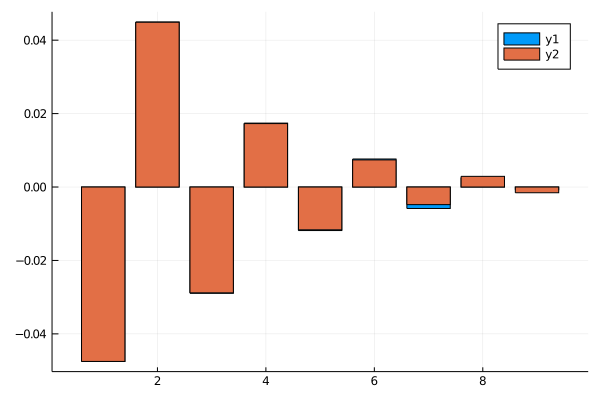

In [121]:
using Plots

u_vals = [U_altro[i][1] for i=1:N-1]
u_vals_osqp = [U_osqp[i][1] for i=1:N-1]

plot(1:N-1, u_vals, seriestype=:bar)
plot!(1:N-1, u_vals_osqp, seriestype=:bar)

In [122]:
objective_value_(X, U) = sum([0.5*X[i]'*Q*X[i] for i=1:N]) + sum([0.5*U[i]'*R*U[i] for i=1:N-1])

@show objective_value_(X_altro, U_altro)
@show objective_value_(X_osqp, U_osqp)

objective_value_(X_altro, U_altro) = 2.8743748542516654
objective_value_(X_osqp, U_osqp) = 2.8741563510569637


2.8741563510569637